In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports scikit-learn
from sklearn.model_selection import train_test_split

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Modèles 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

In [2]:
# Charger les données
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic_data = pd.read_csv(url)

titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
target = "Survived"

titanic_clean = titanic_data.drop(["PassengerId", "Name", "Cabin", "Ticket"], axis=1)

titanic_clean.shape

(891, 8)

## Division train/test

/!\ à faire AVANT le preprocessing => risque de data leak

In [4]:
# X contient toutes les colonnes SAUF la target
X = titanic_clean.drop(target, axis=1)

# y contient la cible
y = titanic_clean[target]

print(f"X : {X.shape}")
print(f"y : {y.shape}")

# Division train test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X : (891, 7)
y : (891,)


## Pipeline de preprocessing

Pipeline: enchaine plusieurs transformations

ColumnTransformer: Applique différentes transformations

In [5]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
cat_features = ['Sex', 'Embarked', 'Pclass']

# numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.to_list()
# cat_features = X.select_dtypes(include=["object", "category"]).columns.to_list()

print(f"Features numériques : {numeric_features}")
print(f"Features catégorielles : {cat_features}")

# Pipeline features

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    # Exemple : Sex (male/female) => 1 ou 0
    ("onehot", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", cat_transformer, cat_features)
    ]
)

Features numériques : ['Age', 'SibSp', 'Parch', 'Fare']
Features catégorielles : ['Sex', 'Embarked', 'Pclass']


## Application du preprocessing

In [6]:
# Etape 1 => fit
preprocessor.fit(X_train)

# Etape 2 => transform train
X_train_prep = preprocessor.transform(X_train)

# Etape 3 => transform test
X_test_prep = preprocessor.transform(X_test)

print(np.isnan(X_test_prep).any())
print(np.isnan(X_train_prep).any())

False
False


## Dummy

In [7]:
dummy = DummyClassifier(
    random_state=42
)

dummy.fit(X_train_prep, y_train)

train_dummy = dummy.score(X_train_prep, y_train)
test_dummy = dummy.score(X_test_prep, y_test)

print(f"Score train : {train_dummy}")
print(f"Score test : {test_dummy}")

Score train : 0.6165730337078652
Score test : 0.6145251396648045


## Regression logistic

In [8]:
lr = LogisticRegression(
    random_state=42
)

lr.fit(X_train_prep, y_train)

train_lr = lr.score(X_train_prep, y_train)
test_lr = lr.score(X_test_prep, y_test)

print(f"Score train : {train_lr}")
print(f"Score test : {test_lr}")

Score train : 0.8103932584269663
Score test : 0.7988826815642458


## Decision tree

In [9]:
tree = DecisionTreeClassifier(
    random_state=42,
    max_depth=5
)

tree.fit(X_train_prep, y_train)

train_tree = tree.score(X_train_prep, y_train)
test_tree = tree.score(X_test_prep, y_test)

print(f"Score train : {train_tree}")
print(f"Score test : {test_tree}")

Score train : 0.8539325842696629
Score test : 0.7988826815642458


## Random Forest

In [10]:
rf = RandomForestClassifier(
    random_state=42,
    max_depth=5,
    n_estimators=100 # nb d'arbres
)

rf.fit(X_train_prep, y_train)

train_rf = rf.score(X_train_prep, y_train)
test_rf = rf.score(X_test_prep, y_test)

print(f"Score train : {train_rf}")
print(f"Score test : {test_rf}")

Score train : 0.8553370786516854
Score test : 0.8100558659217877


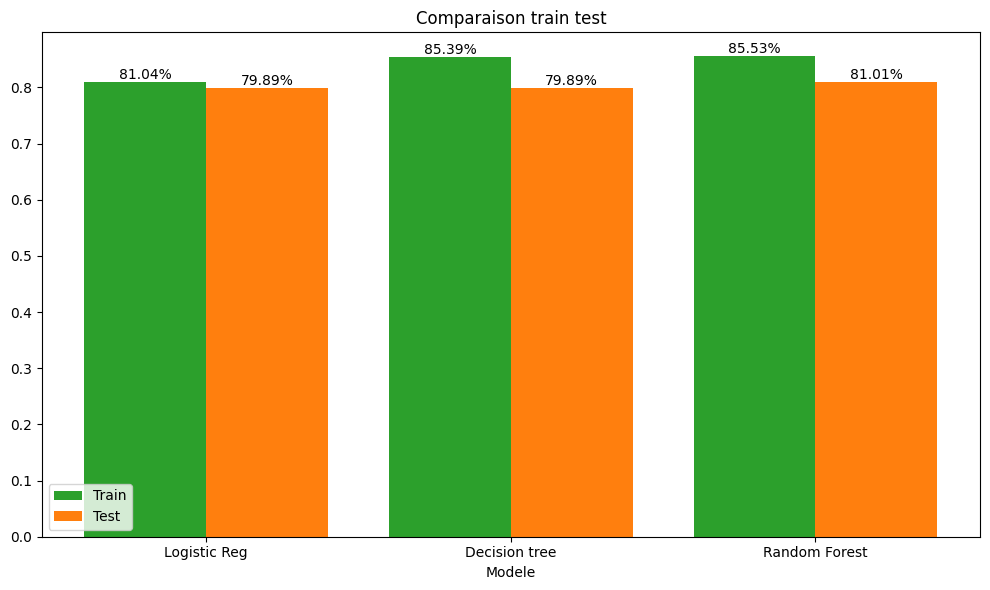

In [11]:
# Créer un DF pour comparer les 3 modèles
comp = pd.DataFrame({
    "Model": ["Logistic Reg", "Decision tree", "Random Forest"],
    "Train": [train_lr, train_tree, train_rf],
    "Test": [test_lr, test_tree, test_rf],
    "Diff": [abs(train_lr-test_lr), abs(train_tree-test_tree), abs(train_rf-test_rf)]
})

# Visualisation
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(comp))
width = 0.40

bar1 = ax.bar(x - width/2, comp["Train"], width, label="Train", color="#2ca02c")
bar2 = ax.bar(x + width/2, comp["Test"], width, label="Test", color="#ff7f0e")

ax.set_xlabel("Modele")
ax.set_title("Comparaison train test")
ax.set_xticks(x)
ax.set_xticklabels(comp["Model"])
ax.legend()

for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.,height, f"{height:0.2%}" ,ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.show()

## Partie 2 : Comparaison avec les métriques

In [12]:
# Métriques de base & Rapport détaillé
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Matrice de confusion
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [13]:
y_pred_lr = lr.predict(X_test_prep)
# format : [[P(class_0), P(class_1)]]
y_prob_lr = lr.predict_proba(X_test_prep)[:,1]

print("Logistic Regression")
print(f"Prédiction : {y_pred_lr[:10]}")
print(f"Proba : {y_prob_lr[:10]}")

y_pred_tree = tree.predict(X_test_prep)
# format : [[P(class_0), P(class_1)]]
y_prob_tree = tree.predict_proba(X_test_prep)[:,1]

print("Decision tree")
print(f"Prédiction : {y_pred_tree[:10]}")
print(f"Proba : {y_prob_tree[:10]}")

y_pred_rf = rf.predict(X_test_prep)
# format : [[P(class_0), P(class_1)]]
y_prob_rf = rf.predict_proba(X_test_prep)[:,1]

print("Random Forest")
print(f"Prédiction : {y_pred_rf[:10]}")
print(f"Proba : {y_prob_rf[:10]}")

Logistic Regression
Prédiction : [0 0 0 0 1 0 1 0 0 0]
Proba : [0.07206038 0.05231286 0.16595366 0.03900038 0.66683354 0.44114919
 0.76463553 0.29077449 0.34979125 0.18569887]
Decision tree
Prédiction : [0 0 0 0 1 0 1 0 0 0]
Proba : [0.11111111 0.11111111 0.11111111 0.11111111 0.63157895 0.09090909
 0.92307692 0.45833333 0.29411765 0.11111111]
Random Forest
Prédiction : [0 0 0 0 1 0 1 0 0 0]
Proba : [0.15313252 0.19889301 0.14268155 0.14411869 0.65076738 0.39142433
 0.79714003 0.36866143 0.47558341 0.22868671]


## Métriques : Précision, recall et f1-score

In [14]:
def calculate_metrics(y_true, y_pred, model_name):
    prec = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return {
        "Modele" : model_name,
        "Précision": prec,
        "Recall": recall,
        "F1-score": f1
    }

metrics_lr = calculate_metrics(y_test, y_pred_lr, "Logistic Regression")
metrics_tree = calculate_metrics(y_test, y_pred_tree, "Décision tree")
metrics_rf = calculate_metrics(y_test, y_pred_rf, "Random Forest")

df_metrics = pd.DataFrame([metrics_lr, metrics_rf, metrics_tree])

df_metrics

,Modele,Précision,Recall,F1-score
0,Logistic Regression,0.779661,0.666667,0.718750
1,Random Forest,0.872340,0.594203,0.706897
2,Décision tree,0.851064,0.579710,0.689655


## Matrice de confusion

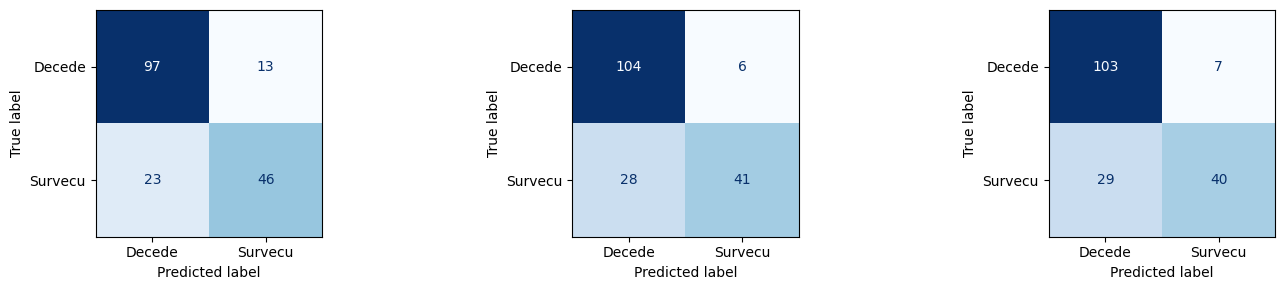

In [16]:
def analyze_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)

    tn, fp, fn, tp = cm.ravel()

    return {
        "model" : model_name,
        "cm" : cm,
        "tn" : tn,
        "fp" : fp,
        "fn" : fn,
        "tp" : tp
    } 

cm_lr = analyze_confusion_matrix(y_test, y_pred_lr, "Logistic Regression")
cm_tree = analyze_confusion_matrix(y_test, y_pred_tree, "Decision tree")
cm_rf = analyze_confusion_matrix(y_test, y_pred_rf, "Random Forest")

cm_list = [cm_lr, cm_rf, cm_tree]

fig, axes = plt.subplots(1, 3, figsize=(15,3))

for idx, (ax, cm_data) in enumerate(zip(axes, cm_list)):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm_data["cm"],
        display_labels=["Decede", "Survecu"]
    )

    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)

plt.tight_layout()
plt.show()

## Classification Report

In [17]:
models_data = [
    ("Logistic Regression", y_pred_lr),
    ("Decision tree", y_pred_tree),
    ("Random Forest", y_pred_rf),
]

for model_name, y_pred in models_data:
    print(model_name)

    report = classification_report(
        y_test,
        y_pred,
        target_names=["Decede", "Survecu"],
        digits=4
    )

    print(report)

Logistic Regression
              precision    recall  f1-score   support

      Decede     0.8083    0.8818    0.8435       110
     Survecu     0.7797    0.6667    0.7188        69

    accuracy                         0.7989       179
   macro avg     0.7940    0.7742    0.7811       179
weighted avg     0.7973    0.7989    0.7954       179

Decision tree
              precision    recall  f1-score   support

      Decede     0.7803    0.9364    0.8512       110
     Survecu     0.8511    0.5797    0.6897        69

    accuracy                         0.7989       179
   macro avg     0.8157    0.7580    0.7704       179
weighted avg     0.8076    0.7989    0.7890       179

Random Forest
              precision    recall  f1-score   support

      Decede     0.7879    0.9455    0.8595       110
     Survecu     0.8723    0.5942    0.7069        69

    accuracy                         0.8101       179
   macro avg     0.8301    0.7698    0.7832       179
weighted avg     0.8204   

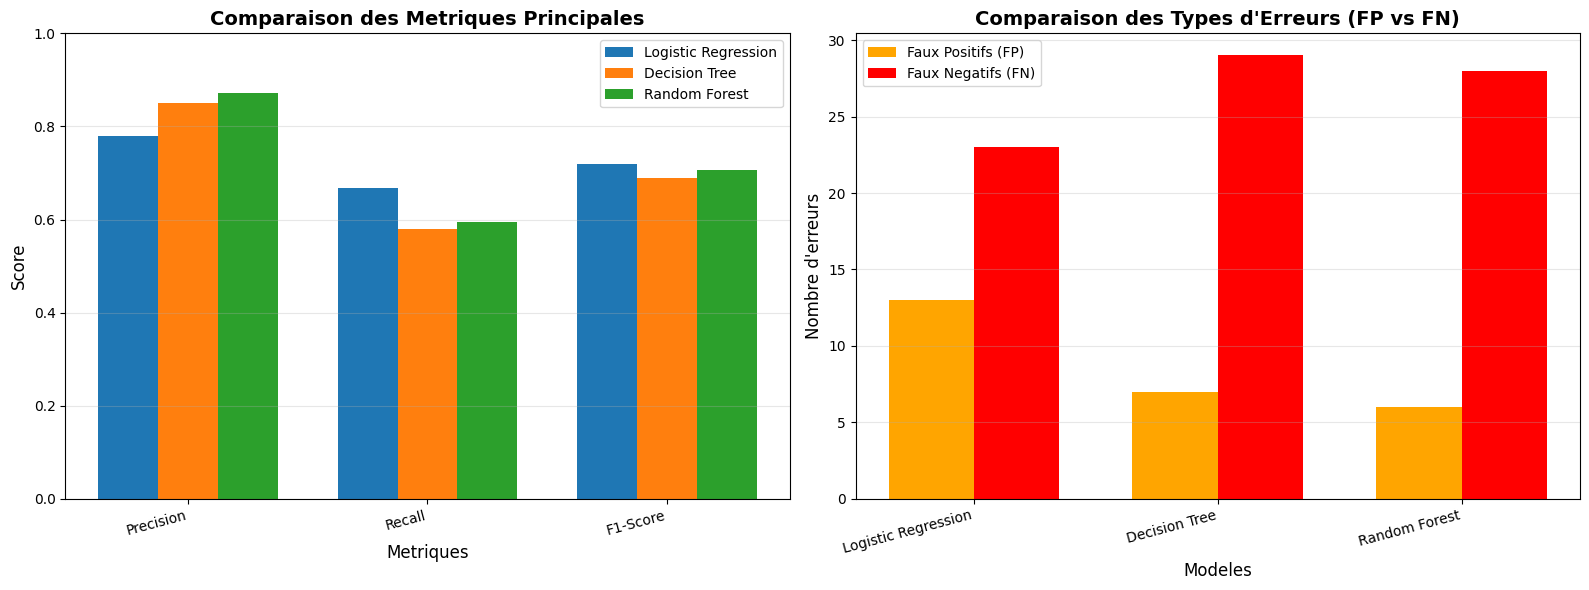

In [18]:
final_comparison = []

for model_name, y_pred, y_proba in [
    ("Logistic Regression", y_pred_lr, y_prob_lr),
    ("Decision Tree", y_pred_tree, y_prob_tree),
    ("Random Forest", y_pred_rf, y_prob_rf)
]:
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Metriques de base
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Ajouter au tableau
    final_comparison.append({
        "Modele": model_name,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1,
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp
    })

# Creer DataFrame
df_final = pd.DataFrame(final_comparison)

# ========== VISUALISATION COMPARATIVE ==========
# Creer un graphique avec 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- SUBPLOT 1 : METRIQUES PRINCIPALES ---
metrics_to_plot = ["Precision", "Recall", "F1-Score"]
x = np.arange(len(metrics_to_plot))
width = 0.25

for idx, row in df_final.iterrows():
    values = [row[m] for m in metrics_to_plot]
    ax1.bar(x + idx*width, values, width, label=row["Modele"])

ax1.set_xlabel("Metriques", fontsize=12)
ax1.set_ylabel("Score", fontsize=12)
ax1.set_title("Comparaison des Metriques Principales", fontsize=14, fontweight="bold")
ax1.set_xticks(x + width)
ax1.set_xticklabels(metrics_to_plot, rotation=15, ha="right")
ax1.legend()
ax1.grid(axis="y", alpha=0.3)
ax1.set_ylim([0, 1])

# --- SUBPLOT 2 : ERREURS (FP vs FN) ---
models_names = df_final["Modele"].tolist()
fp_values = df_final["FP"].tolist()
fn_values = df_final["FN"].tolist()

x2 = np.arange(len(models_names))
width2 = 0.35

ax2.bar(x2 - width2/2, fp_values, width2, label="Faux Positifs (FP)", color="orange")
ax2.bar(x2 + width2/2, fn_values, width2, label="Faux Negatifs (FN)", color="red")

ax2.set_xlabel("Modeles", fontsize=12)
ax2.set_ylabel("Nombre d'erreurs", fontsize=12)
ax2.set_title("Comparaison des Types d'Erreurs (FP vs FN)", fontsize=14, fontweight="bold")
ax2.set_xticks(x2)
ax2.set_xticklabels(models_names, rotation=15, ha="right")
ax2.legend()
ax2.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

## Optimisation hyperparams

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators" : [50, 100, 200, 300],
    "max_depth" : [3, 5, 8, 10, None],
    "min_samples_split" : [2, 5, 10, 15, 20],
    "max_features" : ['sqrt', 'log2', None]
}

rf_base = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_prep, y_train)

print(f"Meilleures hyperparamètres : {grid_search.best_params_}")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Meilleures hyperparamètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 10, 'n_estimators': 300}


In [22]:
best_rf = grid_search.best_estimator_

train_rf_before = train_rf
test_rf_before = test_rf

train_rf_after = best_rf.score(X_train_prep, y_train)
test_rf_after = best_rf.score(X_test_prep, y_test)

print(f"train avant : {train_rf_before} | train après : {train_rf_after}")
print(f"test avant : {test_rf_before} | test après : {test_rf_after}")

train avant : 0.8553370786516854 | train après : 0.9101123595505618
test avant : 0.8100558659217877 | test après : 0.8044692737430168


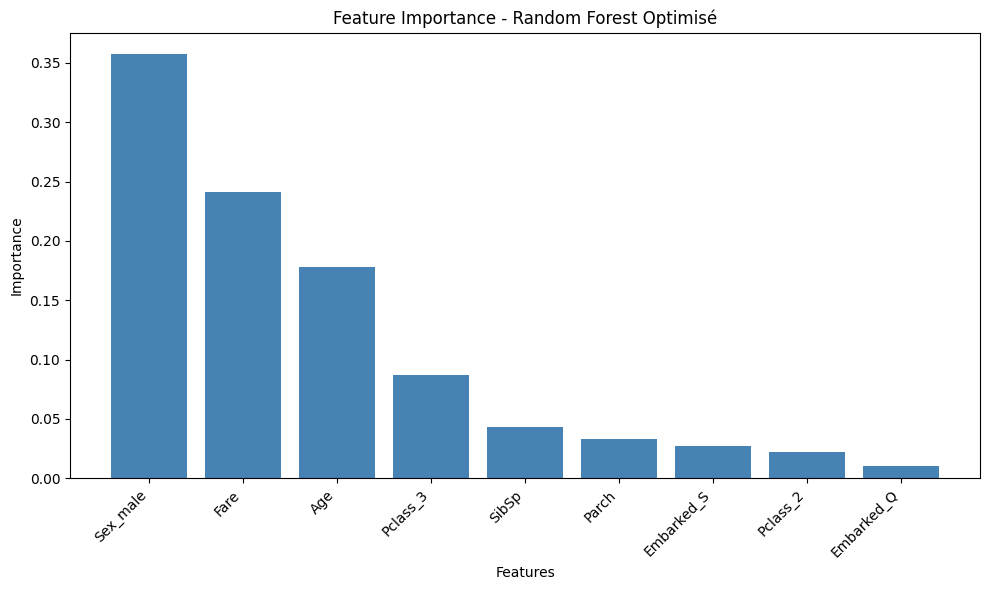


=== Feature Importance (classées) ===
  Sex_male: 0.3575
  Fare: 0.2410
  Age: 0.1779
  Pclass_3: 0.0874
  SibSp: 0.0432
  Parch: 0.0332
  Embarked_S: 0.0272
  Pclass_2: 0.0219
  Embarked_Q: 0.0106


In [23]:
feature_names = numeric_features + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(cat_features))

importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance - Random Forest Optimisé")
plt.bar(range(len(importances)), importances[indices], color='steelblue')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Afficher les importances
print("\n=== Feature Importance (classées) ===")
for i in indices:
    print(f"  {feature_names[i]}: {importances[i]:.4f}")

## Analyse Shap

In [25]:
import shap

# Créer un explainer SHAP pour le random forest
explainer = shap.TreeExplainer(best_rf)

shap_values = explainer(X_test_prep)

c:\Users\Administrateur\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


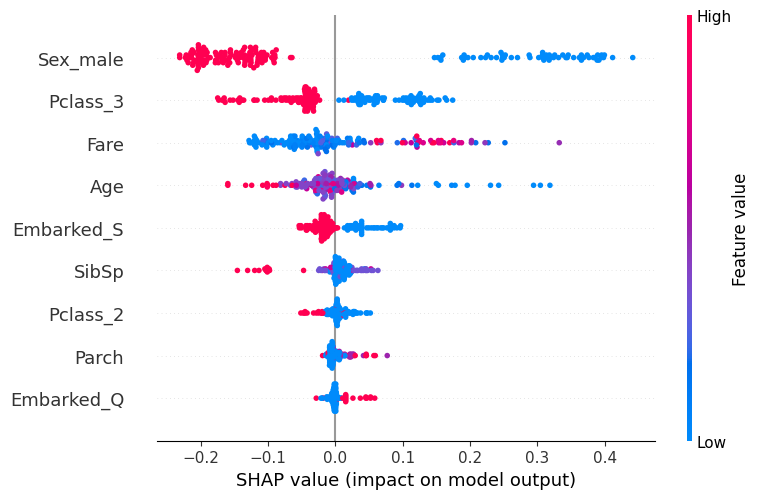

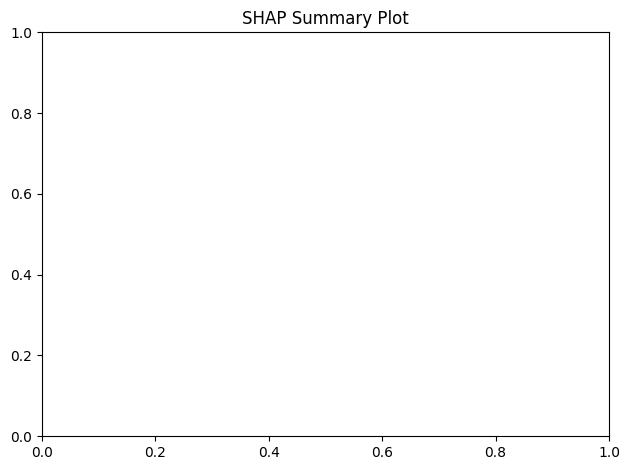

In [26]:
# SHAP Summary Plot  - Vue globale de l'importance feature
shap_values_class1 = shap_values[:,:, 1]
shap_values_class1.feature_names = feature_names

plt.figure(figsize=(10,6))
shap.summary_plot(shap_values_class1, X_test_prep, feature_names)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

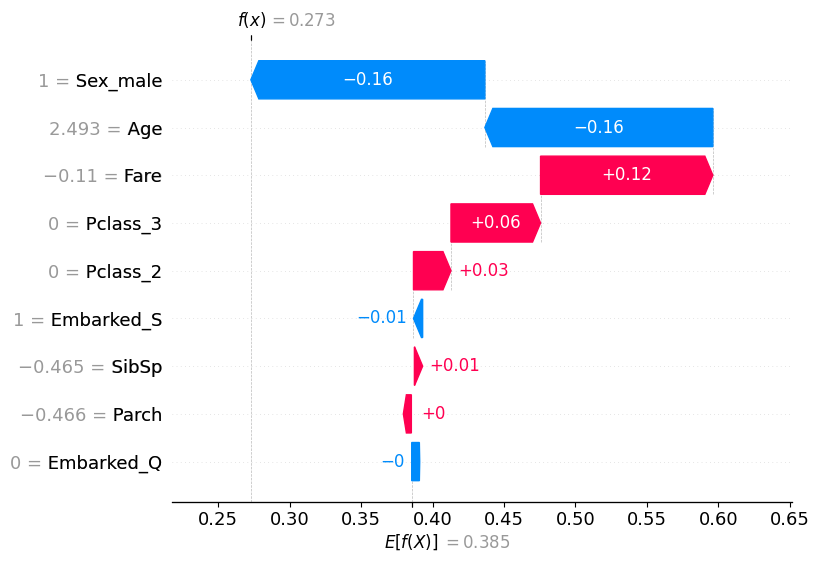

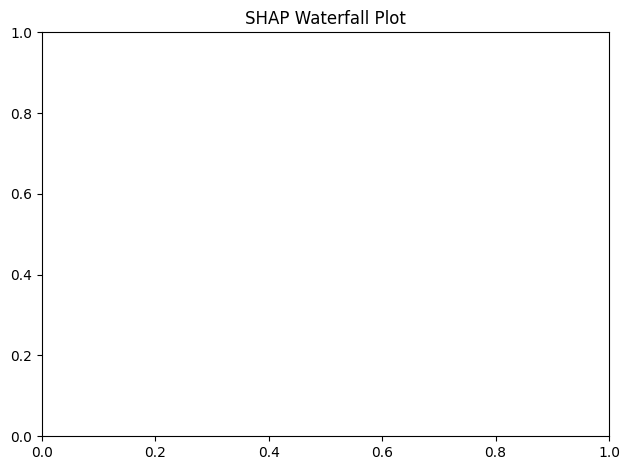

In [30]:
# SHAP Waterfall Plot - Pour une prédiction individuelle

idx = 100

plt.figure(figsize=(10,6))
shap.waterfall_plot(shap_values_class1[idx])
plt.title("SHAP Waterfall Plot")
plt.tight_layout()
plt.show()
